23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:34 - cmdstanpy - INFO - Chain [1] done processing


0                 markt_day
1                     event
2            New Year's Day
3                  Epiphany
4             Easter Monday
5                 Labor Day
6             Ascension Day
7               Whit Monday
8            Corpus Christi
9            Assumption Day
10             National Day
11          All Saints' Day
12    Immaculate Conception
13            Christmas Day
14        St. Stephen's Day
dtype: object
                      ds       trend  yhat_lower  yhat_upper  trend_lower  \
0    2023-11-30 00:00:00  116.373776   28.158724  202.370885   116.373776   
1    2023-11-30 01:00:00  116.347277   32.893717  191.979967   116.347277   
2    2023-11-30 02:00:00  116.320777   36.257410  191.023810   116.320777   
3    2023-11-30 03:00:00  116.294278   32.192195  197.973886   116.294278   
4    2023-11-30 04:00:00  116.267778   19.979979  180.743971   116.267778   
...                  ...         ...         ...         ...          ...   
8454 2025-11-07 15:00:00  1

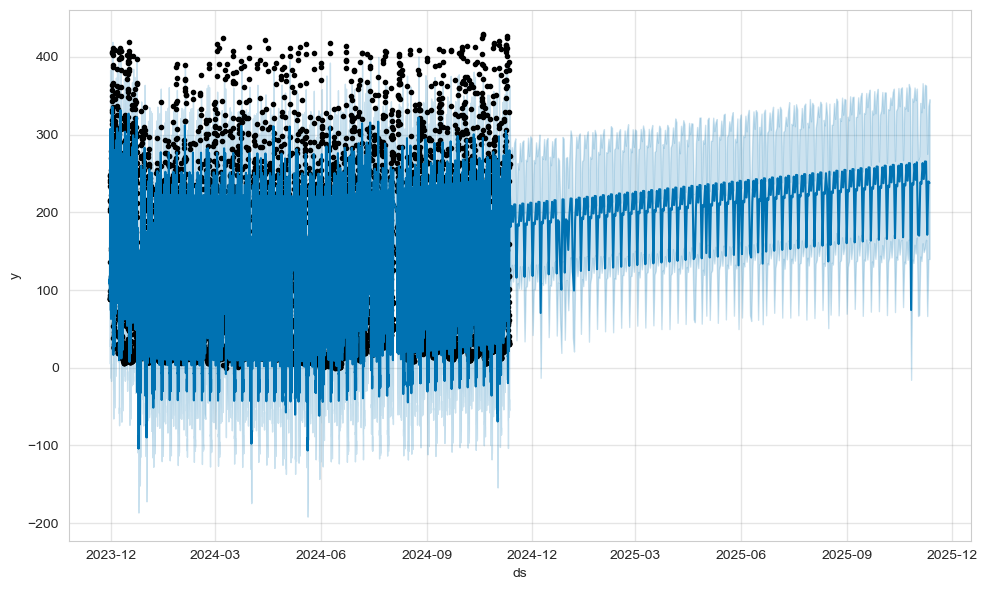

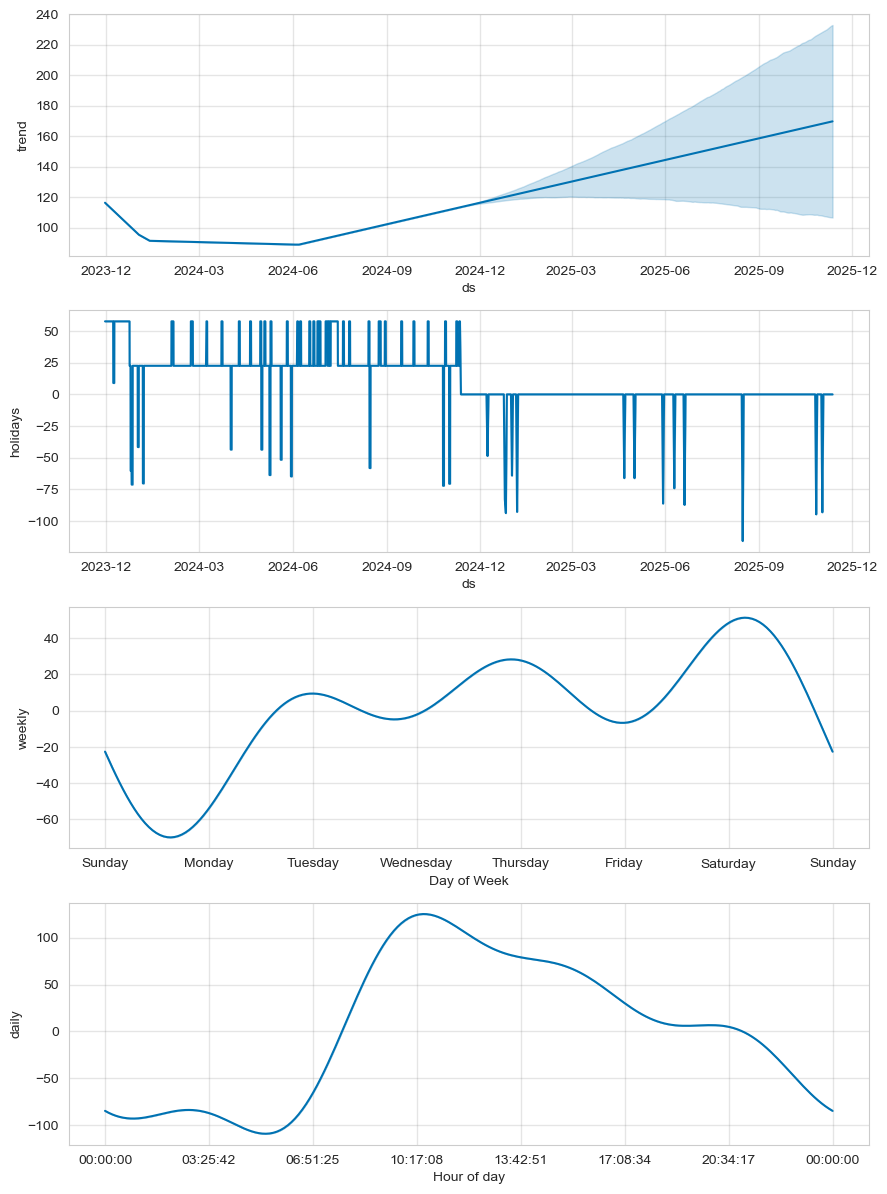

In [60]:
#python -m pip install prophet

import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
import plotly.offline as py
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('./data/out_hourly.csv')

df = pd.DataFrame(data)

df_p = df[['timestamp', 'value']]
df_p = df.rename(columns={'timestamp': 'ds', 'value': 'y'})
df_events = df[['timestamp', 'event_name']]
df_events = df_events[df_events['event_name'].notna()]
df_events['ds'] = pd.to_datetime(df_events['timestamp']).dt.date
df_events = df_events.drop_duplicates(subset=['ds', 'event_name'])
df_events = df_events.drop('timestamp', axis=1)

df_markt = df[['timestamp', 'market_day']]
df_markt = df_markt[df_markt['market_day'].notna()]
df_markt['ds'] = pd.to_datetime(df_markt['timestamp']).dt.date
df_markt = df_markt.drop_duplicates(subset=['ds', 'market_day'])
df_markt = df_markt.drop('timestamp', axis=1)

markt_days = pd.DataFrame({
  'holiday': 'markt_day',
  'ds': df_markt['ds'],
  'lower_window': 0,
  'upper_window': 0,
})
events = pd.DataFrame({
  'holiday': 'event',
  'ds': df_events['ds'],
  'lower_window': 0,
  'upper_window': 0,
})
holidays = pd.concat((markt_days, events))


m = Prophet(holidays=holidays) # object
m.add_country_holidays(country_name='AT')
m.fit(df_p) # modell
print(m.train_holiday_names)
future = m.make_future_dataframe(periods=365) # future data points
future.tail()


forecast = m.predict(future)
forecast[(forecast['markt_day'] + forecast['event']).abs() > 0][
        ['ds', 'markt_day', 'event']][-10:]

#forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() #row in future a predicted value which it names yhat as well as columns for components and uncertainty intervals.
print(forecast)
fig1 = m.plot(forecast)
#If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.
fig2 = m.plot_components(forecast)

#An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.
#plot_plotly(m, forecast)
#plot_components_plotly(m, forecast)


